In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
from pyeit.eit.fem import EITForward, Forward
from pyeit.eit.interp2d import pdegrad, sim2pts

## from pyeit.mesh.shape import thorax
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from sciopy import plot_mesh

from manipulate_mesh import move_el, set_perm_circle, set_sqr_perm

In [2]:
n_el = 16  # number of electrodes
r_cartilage = 0.4  # must be > 0.2

In [3]:
mesh_empty = mesh.create(n_el, h0=0.1)
mesh_obj = mesh.create(n_el, h0=0.1)

2D mesh status:
376 nodes, 686 elements


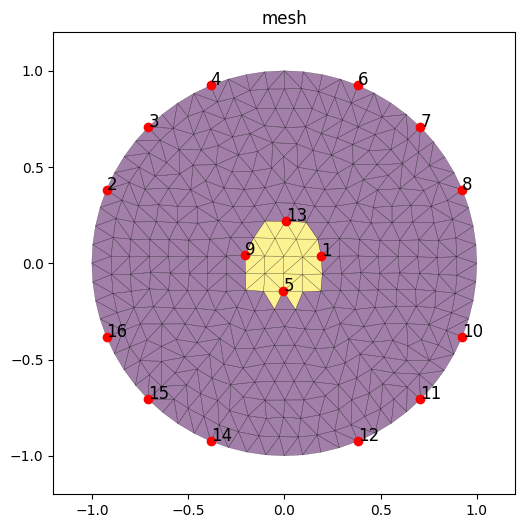

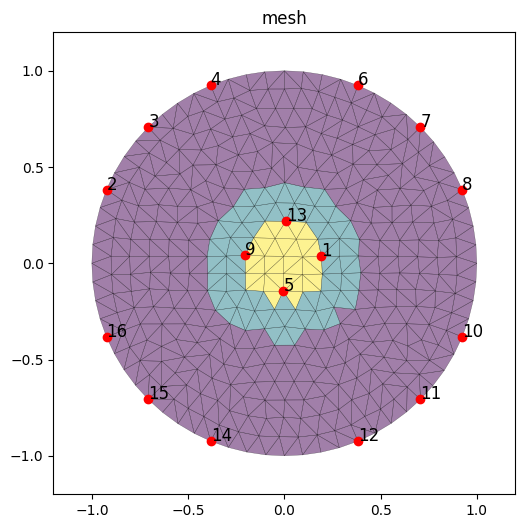

In [4]:
# change electrode positions
el_posis = [(0.2, 0), (0, -0.2), (-0.2, 0.0), (0, 0.2)]
lst = [0, 4, 8, 12]

mesh_empty = move_el(mesh_empty, el_idx=lst, target_x_y=el_posis)
mesh_obj = move_el(mesh_obj, el_idx=lst, target_x_y=el_posis)


el_pos = mesh_empty.el_pos

mesh_empty.print_stats()

# change permittivity
anomaly_bone = PyEITAnomaly_Circle(center=[0, 0], r=0.2, perm=10.0)
anomaly_cartilage = PyEITAnomaly_Circle(center=[0, 0], r=r_cartilage, perm=5.0)

mesh_empty = mesh.set_perm(mesh_empty, anomaly=anomaly_bone, background=1.0)

mesh_obj = mesh.set_perm(mesh_obj, anomaly=anomaly_cartilage, background=1.0)
mesh_obj = set_perm_circle(mesh_obj, anomaly=anomaly_bone)

plot_mesh(mesh_empty)
plot_mesh(mesh_obj)

In [5]:
el_pos = mesh_obj.el_pos
n_el = len(el_pos)

# extract node, element, alpha
pts = mesh_obj.node
tri = mesh_obj.element
x, y = pts[:, 0], pts[:, 1]


""" 1. FEM forward simulations """
# setup EIT scan conditions
protocol_obj = protocol.create(n_el, dist_exc=14, step_meas=1, parser_meas="std")

# Define electrode current sink and current source
ex_line = protocol_obj.ex_mat[0].ravel()

# calculate simulated data using FEM
fwd = Forward(mesh_obj)
f = fwd.solve(ex_line)
f = np.real(f)

# calculate simulated v_data
fwd_v = EITForward(mesh_empty, protocol_obj)
v0 = fwd_v.solve_eit(perm=mesh_empty.perm)
v1 = fwd_v.solve_eit(perm=mesh_obj.perm)

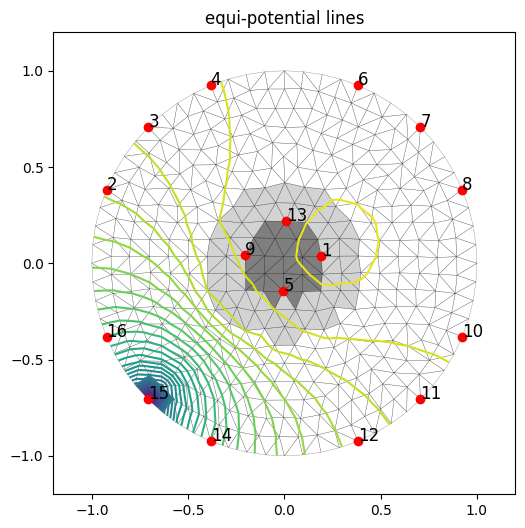

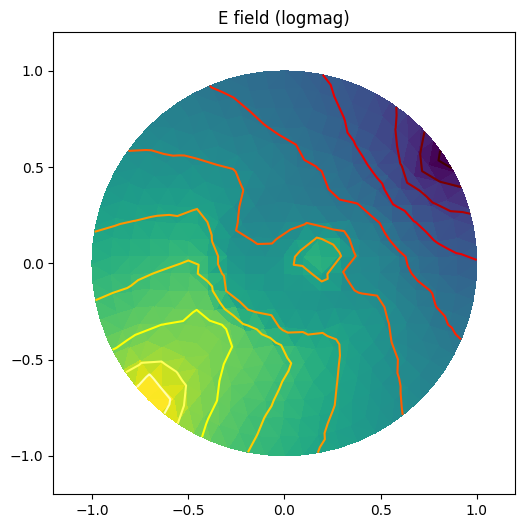

In [6]:
""" 2. plot """
fig, ax1 = plt.subplots(figsize=(9, 6))
# draw equi-potential lines
vf = np.linspace(min(f), max(f), 32)
# vf = np.sort(f[el_pos])
# Draw contour lines on an unstructured triangular grid.
ax1.tricontour(x, y, tri, f, vf, cmap=plt.cm.viridis)

# Create a pseudocolor plot of an unstructured triangular grid
ax1.tripcolor(
    x,
    y,
    tri,
    np.real(mesh_obj.perm_array),
    edgecolors="k",
    shading="flat",
    alpha=0.5,
    cmap=plt.cm.Greys,
)
# draw electrodes
ax1.plot(x[el_pos], y[el_pos], "ro")
for i, e in enumerate(el_pos):
    ax1.text(x[e], y[e], str(i + 1), size=12)
ax1.set_title("equi-potential lines")
# clean up
ax1.set_aspect("equal")
ax1.set_ylim([-1.2, 1.2])
ax1.set_xlim([-1.2, 1.2])
fig.set_size_inches(6, 6)
# fig.savefig('demo_bp.png', dpi=96)
plt.show()

ux, uy = pdegrad(pts, tri, f)
uf = ux**2 + uy**2
uf_pts = sim2pts(pts, tri, uf)
uf_logpwr = 10 * np.log10(uf_pts)

fig, ax = plt.subplots(figsize=(9, 6))
# Draw contour lines on an unstructured triangular grid.
ax.tripcolor(x, y, tri, uf_logpwr, cmap=plt.cm.viridis)
ax.tricontour(x, y, tri, uf_logpwr, 10, cmap=plt.cm.hot)
ax.set_aspect("equal")
ax.set_ylim([-1.2, 1.2])
ax.set_xlim([-1.2, 1.2])
ax.set_title("E field (logmag)")
plt.show()

<StemContainer object of 3 artists>

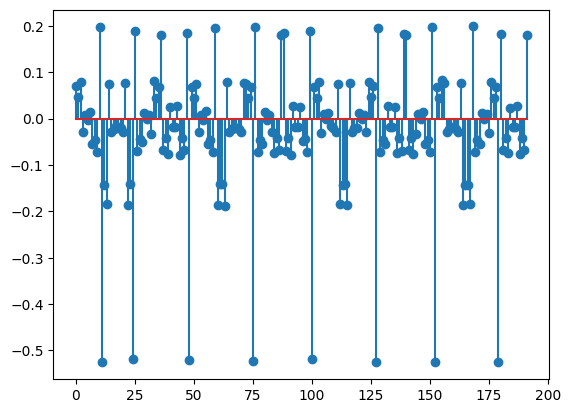

In [7]:
plt.stem(v0)

<StemContainer object of 3 artists>

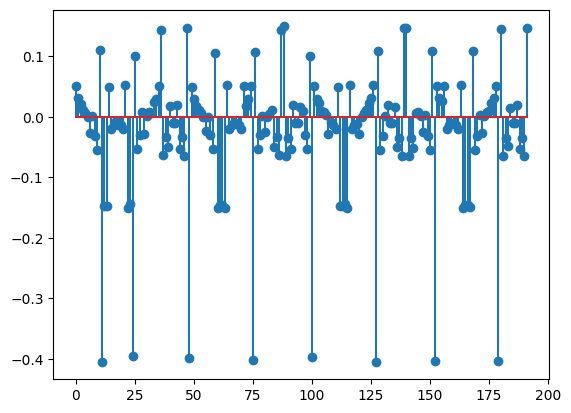

In [8]:
plt.stem(v1)